<h1> Spatial Clustering Insights from the 2023 City of Vancouver Property Tax Report </h1>
Members: Yujia Huang, Moira Guanlao, Halley Suarez, Leonardo Wu

In [1]:
## Load Relevant Libraries 

# Tidyverse library used for wrangling and tidying data
library(tidyverse)

# Tidymodels library used for kmeans clustering
library(tidymodels)

# Broom used for tidy visualization of clustering
library(broom)

# ggpairs used to sort out which variables correlate strongly with each other
library(GGally)

seed <- 9876

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

<div class="alert alert-block alert-info">
<h1> Introduction </h1>
Unaffordable housing is an ongoing major problem in Canada's largest cities, a notorious example being housing in Vancouver. Extensive data on property values in the city of Vancouver is available as part of the City's efforts in transparent government. In this data, there is an opportunity to explore the behaviour of property values and its viability as a proxy measurement for housing costs in the city.
    
Our project is dedicated to exploring the dynamic relationship between housing property value and spatial and temporal factors.  Modeling Spatial Variation in Housing Prices suggests that the value of the location is embodied in housing prices. Therefore, the absolute locations should not be separated from other determiners of property values. It recommends that when creating housing value models, the researchers should always allow other independent attributes to interact with {x, y} coordinates or the absolute locations of properties (Fik, Ling, Mulligan, 2003). In our research, with the clustering method and the "LAND_COORDINATE" variables, we cluster the properties in Vancouver based on locations and make it intertwined with other interactive factors. For instance, our temporal factor is “YEAR_BUILT”. 

The question we want to answer is: “Can property attributes predict neighbourhood boundaries?”. The purpose of our project is to determine whether the clustering pattern will align with neighbourhood boundaries while also considering what spatiotemporal property variables contribute to geolocation clustering in the city of Vancouver. We will take a look at the boundaries drawn, see where they are located, and how clearly they are distinguished. We will plot the Vancouver neighbourhood map with, “NEIGHBOURHOOD_CODE” which is included in our dataset. 

Our model integrates two datasets from the City of Vancouver Open Data Portal: Property Tax Report and Property Polygons Report. The Property Tax Report dataset contains tax information collected by BC Assessment on all properties within the municipal boundaries of Vancouver from 2020 onwards. The dataset contains the financial information and address of these properties. The Property Polygons dataset contains geographic information that is not present in the Property Tax Report dataset, mapping each tax coordinate to its associated latitude and longitude. By combining the two datasets, we can plot and observe how absolute locations intertwine with property attributes.
  
</div>


<h1> 1. Data Specification and Wrangling </h1>
This project uses data from the City of Vancouver Open Data Portal 

In [2]:
#setting seed
set.seed(9876)
seed <- 9876

## 2023 CoV Property Tax Report Dataset imported by url (HTTP GET)
ptax_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-tax-report/exports/csv?lang=en&refine=report_year%3A%222023%22&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
ptax_df <- read_delim(ptax_url, delim = ";") |>
            # Select relevant features for analysis
            select(LEGAL_TYPE,
                   LAND_COORDINATE, 
                   ZONING_CLASSIFICATION,
                   CURRENT_LAND_VALUE,
                   CURRENT_IMPROVEMENT_VALUE,
                   YEAR_BUILT,
                   BIG_IMPROVEMENT_YEAR,
                   NEIGHBOURHOOD_CODE,
                   TAX_LEVY)

## CoV Property Parcel Polygons Dataset
# For use with 2023 CoV Property Tax Report Dataset to merge geographic location values

parcel_url <- "https://opendata.vancouver.ca/api/explore/v2.1/catalog/datasets/property-parcel-polygons/exports/csv?lang=en&timezone=America%2FLos_Angeles&use_labels=true&delimiter=%3B"
parcel_df <- read_delim(parcel_url, delim = ";") |>
            # Select relevant features for analysis
            select(TAX_COORD, geo_point_2d) |>
            rename(LAND_COORDINATE = TAX_COORD)

# Merge CoV Property Parcel Polygons Dataset to attain geographic (lat,long) location of property
ptax_parcel_merged <- inner_join(ptax_df, parcel_df, by = "LAND_COORDINATE", relationship = "many-to-many") |>
# Separate (lat,long) into respective columns
            separate(col = geo_point_2d,
                     into = c("lat", "long"),
                     sep = ",") |>
# Convert (lat,long) into numeric data
            mutate(lat = as.double(lat)) |>
            mutate(long = as.double(long))

Rows: 220840 Columns: 29
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (19): PID, LEGAL_TYPE, FOLIO, LAND_COORDINATE, ZONING_DISTRICT, ZONING_C...
dbl (10): TO_CIVIC_NUMBER, CURRENT_LAND_VALUE, CURRENT_IMPROVEMENT_VALUE, TA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 100164 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (5): STREETNAME, TAX_COORD, SITE_ID, Geom, geo_point_2d
dbl (1): CIVIC_NUMBER

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [48]:
## Data Tidying
# Filter for housing properties only by zone
property_housing_only <- ptax_parcel_merged |>
    filter(ZONING_CLASSIFICATION == c("Comprehensive Development",
                                      # NOTE: Comprehensive Developments are mixed-use, and could look like an 
                                      # apartment building with shops below, or a shopping mall with a few apartments
                                      # above. This report acknowledges the limitations of this in further sections.
                                      "Single Detached House",
                                      "Multiple Dwelling"))

print(paste("Entry Count before NA and 0 removal: ", nrow(property_housing_only))) 
property_housing_only <- property_housing_only |>
                            filter(CURRENT_LAND_VALUE > 0,
                                   CURRENT_IMPROVEMENT_VALUE > 0,
                                   YEAR_BUILT > 0,
                                   BIG_IMPROVEMENT_YEAR > 0) |>
                            drop_na()
print(paste("Entry Count after NA and 0 removal: ", nrow(property_housing_only)))

# Summary table counting each housing type
property_summ_table <- property_housing_only |>
    group_by(ZONING_CLASSIFICATION) |>
    summarize(COUNT = n())
property_summ_table 

Warning message in ZONING_CLASSIFICATION == c("Comprehensive Development", "Single Detached House", :
“longer object length is not a multiple of shorter object length”


[1] "Entry Count before NA and 0 removal:  60741"
[1] "Entry Count after NA and 0 removal:  58835"


ZONING_CLASSIFICATION,COUNT
<chr>,<int>
Comprehensive Development,26335
Multiple Dwelling,10405
Single Detached House,22095


LEGAL_TYPE,LAND_COORDINATE,ZONING_CLASSIFICATION,CURRENT_LAND_VALUE,CURRENT_IMPROVEMENT_VALUE,YEAR_BUILT,BIG_IMPROVEMENT_YEAR,NEIGHBOURHOOD_CODE,TAX_LEVY,lat,long
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
STRATA,32071895,Comprehensive Development,597000,350000,2016,2016,023,2633.33,49.23355,-123.0242
LAND,79015654,Multiple Dwelling,2733000,422000,1988,1988,011,11066.10,49.22606,-123.1223
STRATA,81315093,Comprehensive Development,1530000,343000,2004,2004,011,5208.25,49.21761,-123.1276
LAND,74119765,Single Detached House,1928000,100000,1973,1975,016,8177.27,49.23645,-123.0945
LAND,75718836,Single Detached House,1851000,1125000,2020,2020,016,8717.36,49.23005,-123.1029
LAND,75719563,Single Detached House,1695000,294000,1921,2005,016,8517.75,49.23047,-123.0983


<h2> Aggregate Measurements </h2>
Due to the fact that there are several properties sharing the same address (e.g. apartments), we need to calculate the sum of all housing prices at the same location. The graph below shows that the density of housing with the same address reinforces the necessity of aggregation measurements.


`summarise()` has grouped output by 'lat'. You can override using the `.groups`
argument.


lat,long,NEIGHBOURHOOD_CODE,AGGREGATE_CURRENT_LAND_VALUE,AGGREGATE_IMPROVEMENT_VALUE,MEAN_YEAR_BUILT,MEAN_BIG_IMPROVEMENT_YEAR,MEAN_TAX_LEVY,SAME_ADDRESS_ENTRIES
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
49.20317,-123.0267,018,10053201,4000,2005,2005,56736.200,1
49.20330,-123.0275,018,9875399,4000,2005,2005,55489.800,1
49.20338,-123.1291,007,2700,8300,1998,1998,489.620,1
49.20404,-123.1358,012,1609000,298900,1975,1975,1326.328,4
49.20429,-123.0247,007,2700,8300,1998,1998,489.620,1
49.20443,-123.0339,018,12831000,47198000,2022,2022,170154.000,1


[1] "Same-address Property Value Entries: 27139  /  58835  ( 46.13 % ) total"


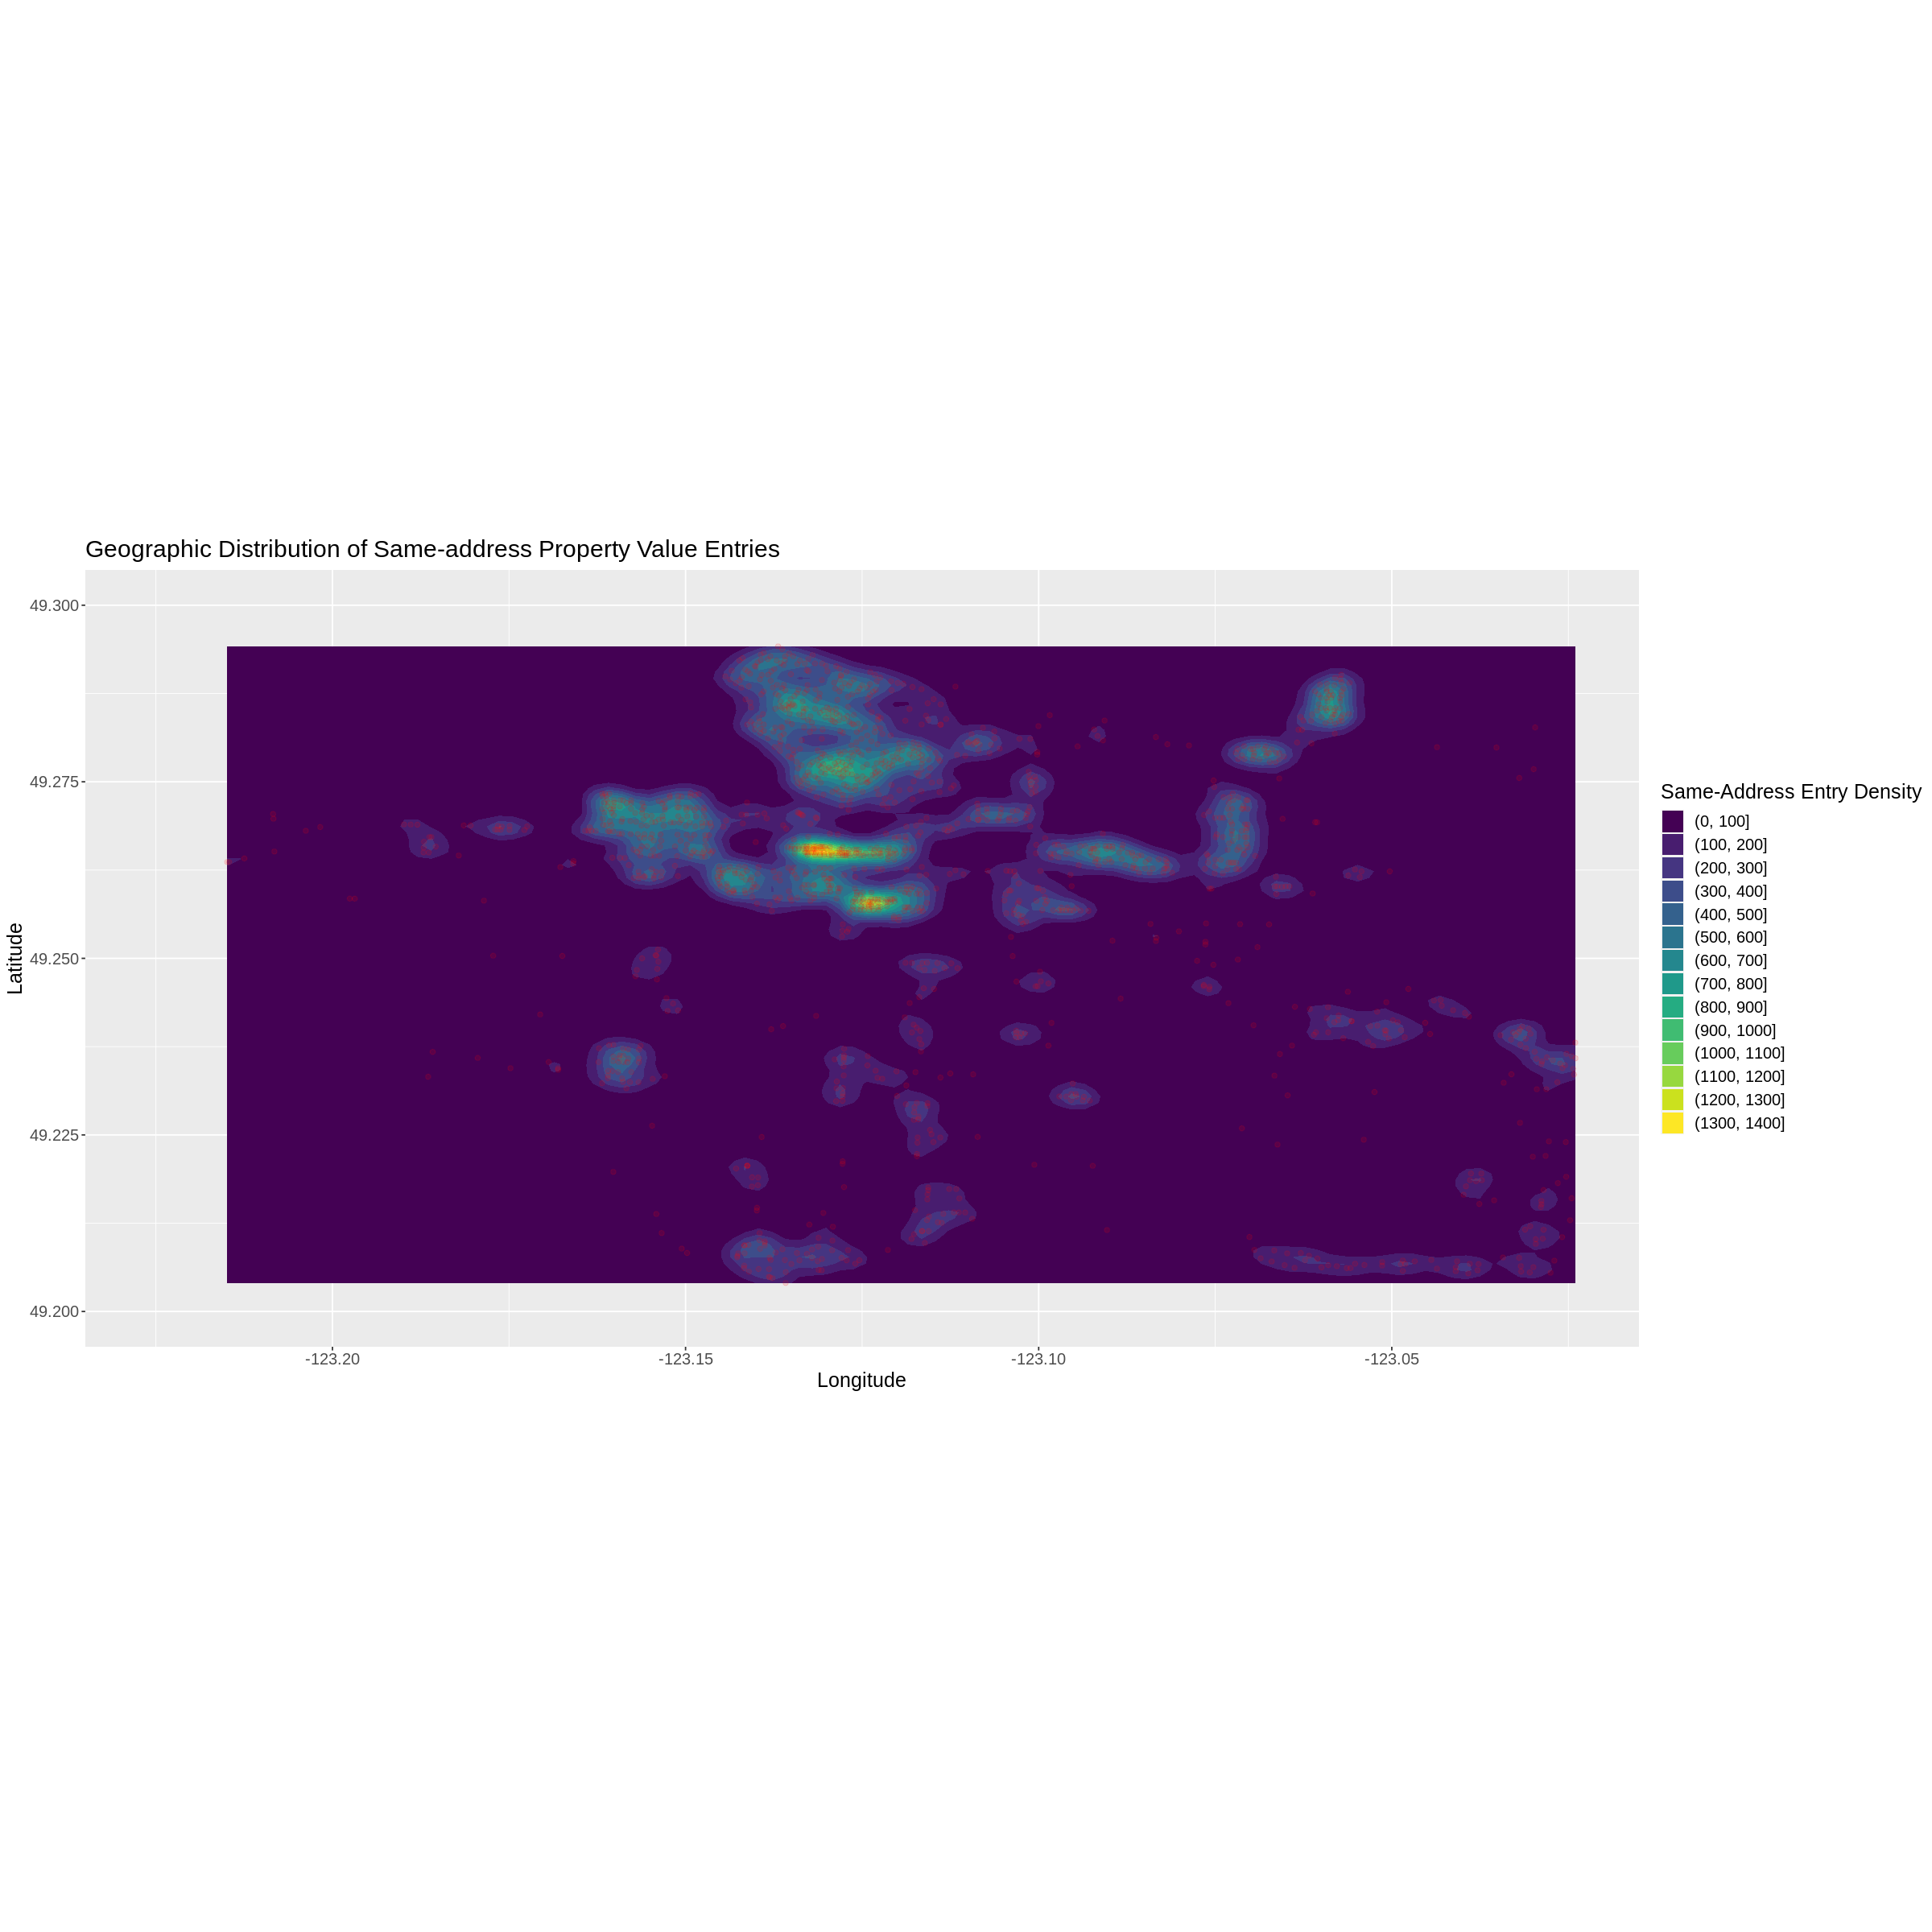

In [51]:
# Mode Function
Mode <- function(x) {
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

## Address Aggregation
# Computation of aggregate statistics:
housing_aggregated <- property_housing_only |>
                        mutate(NEIGHBOURHOOD_CODE = as.factor(NEIGHBOURHOOD_CODE)) |>
                        group_by(lat, long) |>
                        arrange(long) |>
                        summarize(NEIGHBOURHOOD_CODE = Mode(NEIGHBOURHOOD_CODE),
                                  AGGREGATE_CURRENT_LAND_VALUE = sum(CURRENT_LAND_VALUE),
                                  AGGREGATE_IMPROVEMENT_VALUE = sum(CURRENT_IMPROVEMENT_VALUE),
                                  MEAN_YEAR_BUILT = mean(YEAR_BUILT),
                                  MEAN_BIG_IMPROVEMENT_YEAR = mean(BIG_IMPROVEMENT_YEAR),
                                  MEAN_TAX_LEVY = mean(TAX_LEVY),
                                  SAME_ADDRESS_ENTRIES = n()) |>
                        as_tibble()

print(paste("Same-address Property Value Entries:", nrow(housing_aggregated), " / ", nrow(property_housing_only),
            " (", signif(nrow(housing_aggregated) / nrow(property_housing_only) * 100, 4), "% ) total"))

# Plot Geographic distribution of Same-Address Property Tax Report Entries
options(repr.plot.width = 20, repr.plot.height =20)
property_plot <- housing_aggregated |>
                filter(SAME_ADDRESS_ENTRIES > 1) |>
                ggplot(aes(x=long,y=lat, z= SAME_ADDRESS_ENTRIES)) +
                geom_density_2d_filled(adjust = 1/4) +
                geom_point(alpha = 0.125, color = "red") +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude", 
                     fill = "Same-Address Entry Density", 
                     title = "Geographic Distribution of Same-address Property Value Entries") +
                theme(text = element_text(size = 15))
property_plot

<h1> 2. Calculating Spatial Centroids </h1>

This project will use the spatial centroids of properties within each neighbourhood coded in the Property Tax Report  as an external validation.

<h2> Neighbourhood Centroids using All Properties </h2>

In [85]:
## Housing Centroids
# Assign Neighbourhood Names to Neighbourhood Codes in the Property Tax Dataset
ptax_centroids <- housing_aggregated |>
        group_by(NEIGHBOURHOOD_CODE) |>
        mutate(lat = as.numeric(lat)) |>
        mutate(long = as.numeric(long)) |>
        summarize(centroid_lat = mean(lat),
                  centroid_long = mean(long))

neighbourhoods <- tibble(NEIGHBOURHOOD_CODE = c("001", "002", "003", "004", "005", "006", "007", "008", "009", "010", "011", "012", "013", "014", "015",
                                                "016", "017", "018", "019", "020", "021", "022", "023", "024", "025", "026", "027", "028", "029", "030"),
                         NEIGHBOURHOOD_NAME = c("Point Grey", "Kitsilano", "Dunbar", "Arbutus", 
                                                "Kerrisdale",  "Southlands", "Fairview", "Shaughnessy", "South Granville", 
                                                "Cambie", "Oakridge/South Cambie", "Marpole", "Mt. Pleasant East", "Hastings", 
                                                "Fraser", "Main", "South Vancouver", "South Marine", "Knight/Victoria", "Hastings Sunrise", 
                                                "Renfrew", "Renfrew Heights", "Collingwood", "Killarney", "Fraser View/Champlain Heights", 
                                                "Gastown/Chinatown", "West End", "Coal Harbour", "Yaletown", "False Creek"))
ptax_centroids <- inner_join(ptax_centroids, neighbourhoods, by = "NEIGHBOURHOOD_CODE")

In [1]:
## Neighbourhood Centroid Plot
options(repr.plot.width = 17, repr.plot.height =10)
neighbourhood_plot <- housing_aggregated |>
                mutate(lat = as.double(lat)) |>
                mutate(long = as.double(long)) |>
                ggplot(aes(x=long,y=lat,color=NEIGHBOURHOOD_CODE, color = "black")) +
                geom_point(alpha = 0.5, size = 0.125) +
                geom_label(data = ptax_centroids, aes(x=centroid_long, y=centroid_lat, label=NEIGHBOURHOOD_NAME), hjust = 0.125, vjust = 1.5) +
                geom_point(data = ptax_centroids, aes(x=centroid_long, y=centroid_lat), size = 5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude",
                     color = "Neighbourhood Code",
                     title = "Geographic Distribution of Vancouver Neighbourhoods") +
                theme(text = element_text(size = 15))
neighbourhood_plot

ERROR: Error in ggplot(mutate(mutate(housing_aggregated, lat = as.double(lat)), : could not find function "ggplot"


<div class="alert alert-block alert-info">
<h1> Method </h1> K-Means Clustering on Property Data from the 2023 City of Vancouver Property Tax Report
This project uses data from the City of Vancouver Open Data Portal.

> - 1. Preliminary Feature Selection using GGPairs
        - Variables with strong correlation eliminated
> - 2. Model Tuning using Elbow Plot Method
        - Some behaviours
> - 3. Final Feature Selection using Kernel Density Plot
        - Confirms results of feature selection and model tuning
> - 4. Visualize clustering Model with optimal k 
</div>

<h1> 3. Feature Selection and Model Parameter Tuning </h1> 
The model will be tuned a priori using the elbow plot method, and the project will qualitively compare the results using the calculated spatial centroids from Section 3 above. From this qualitative comparison, 

First, we will narrow down the number of variables to consider. This is because many of the variables included in the data set are representative of similar things, for example "current land value" and "tax levy" could both be used as measures of how much a certain location is worth. Thus, we will first use ggpairs to form a matrix of pairs plots to see how each of the variables correlate with each other. Variables that have a moderately strong correlations will be grouped together, and the anlysis will proceed with only one variable of each group.

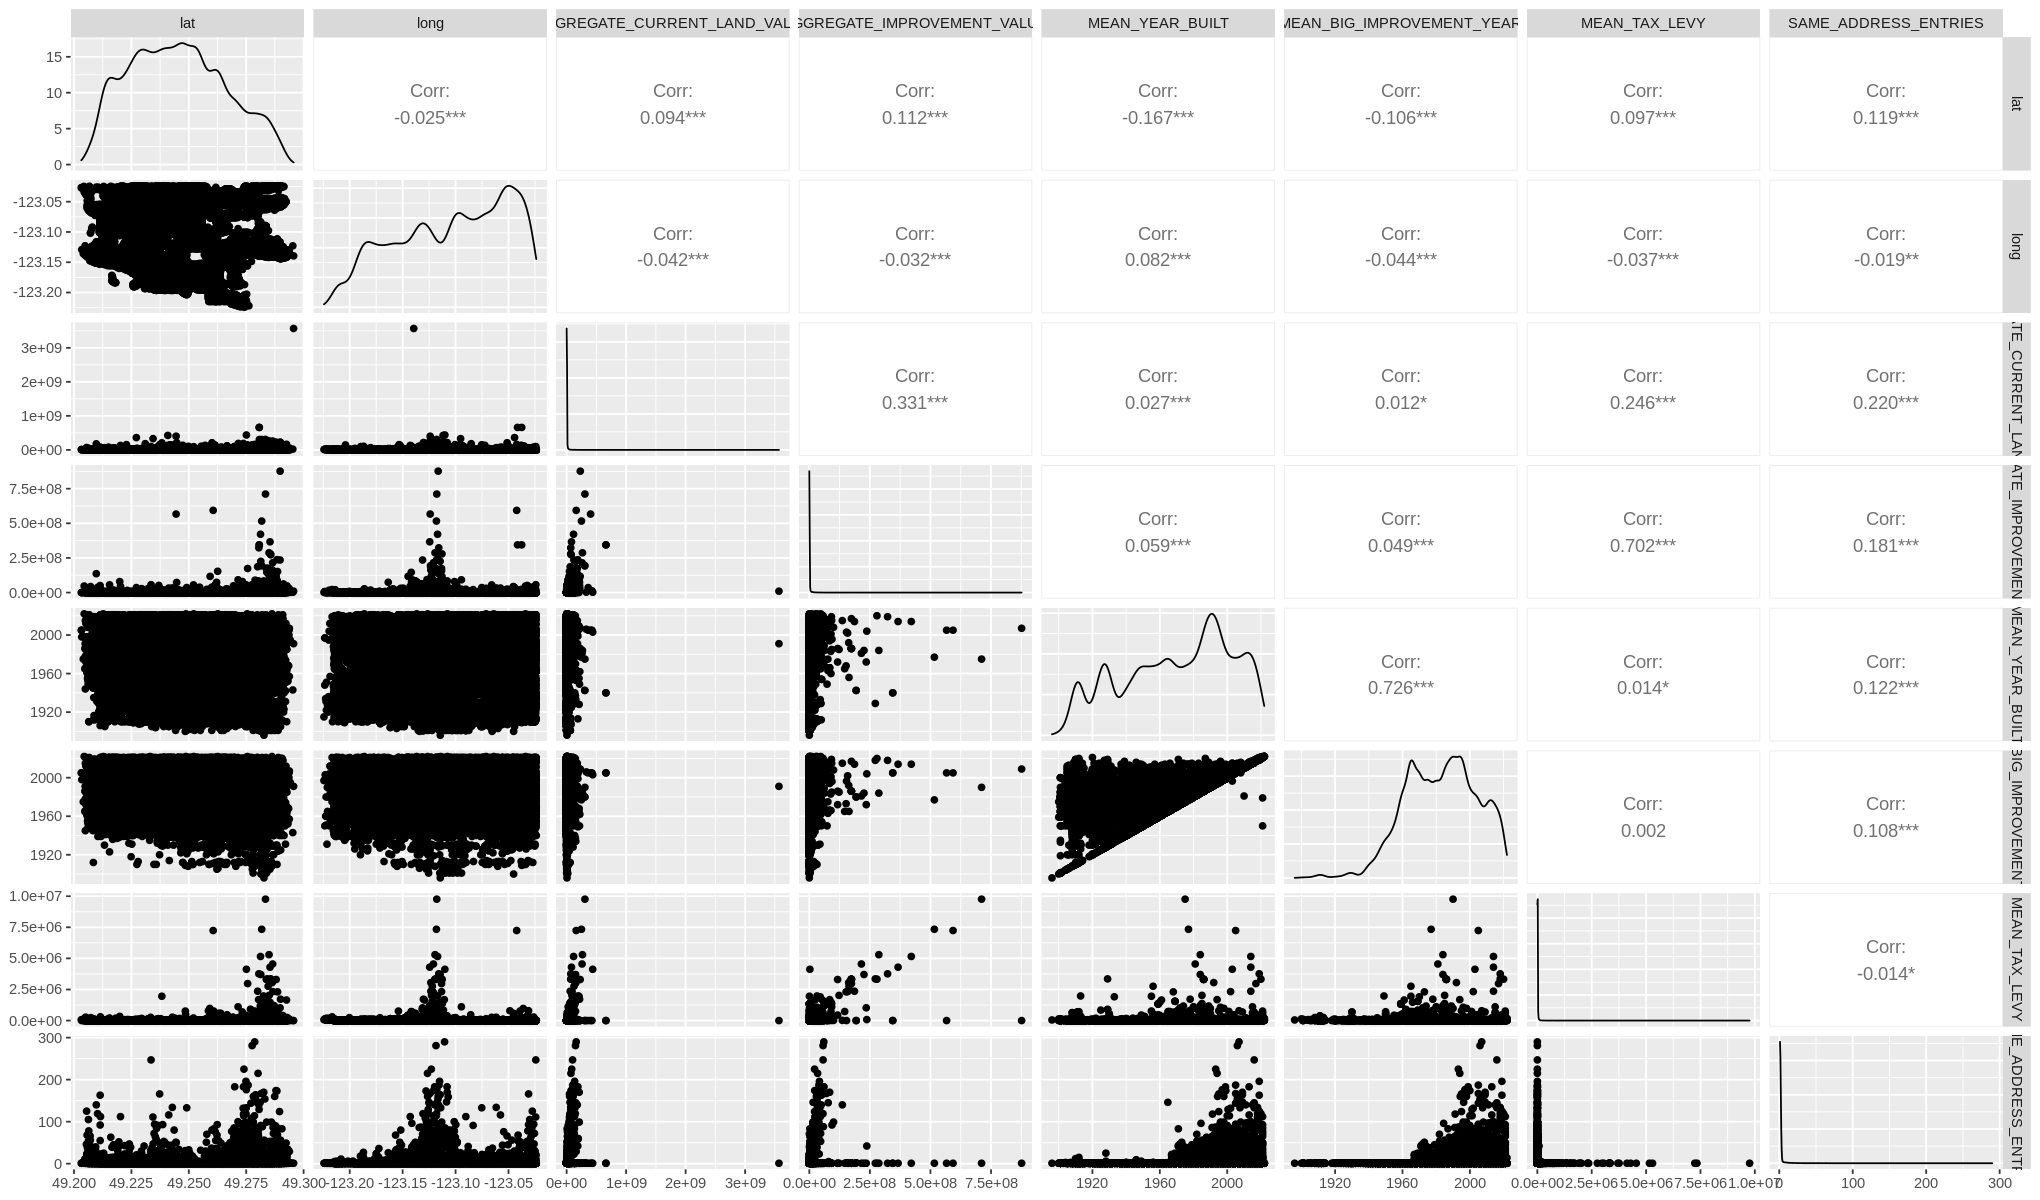

In [55]:
#using ggpairs to find how all the variable correlate with each other
ggpairs_plot <- housing_aggregated |>
    select(-NEIGHBOURHOOD_CODE) |>
    ggpairs()
ggpairs_plot

Based on the ggpairs plots, year built (MEAN_YEAR_BUILT) and big improvement year (MEAN_BIG_IMPROVEMENT_YEAR) have a strong correlation. In addition, many data points have the same value for year built and big improvement year, since not all buildings had major improvements. Thus, of the two we will proceed with only year built.

Likewise, current land value (AGGREGATE_CURRENT_LAND_VALUE), current improvement value (AGGREGATE_CURRENT_IMPROVEMENT_VALUE), and tax levy (MEAN_TAX_LEVY) have moderately strong correlations, so we will proceed with only current land value.

Latitude (lat) and longitude (long) have very weak correlations with all other variables (and with each other), so both will be kept.

Variables kept: current land value, year built, latitude, longitude.

Next, we determine the k number of clusters to use in our model by constructing an elbow plot.

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1356950)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1356950)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1356950)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1356950)”


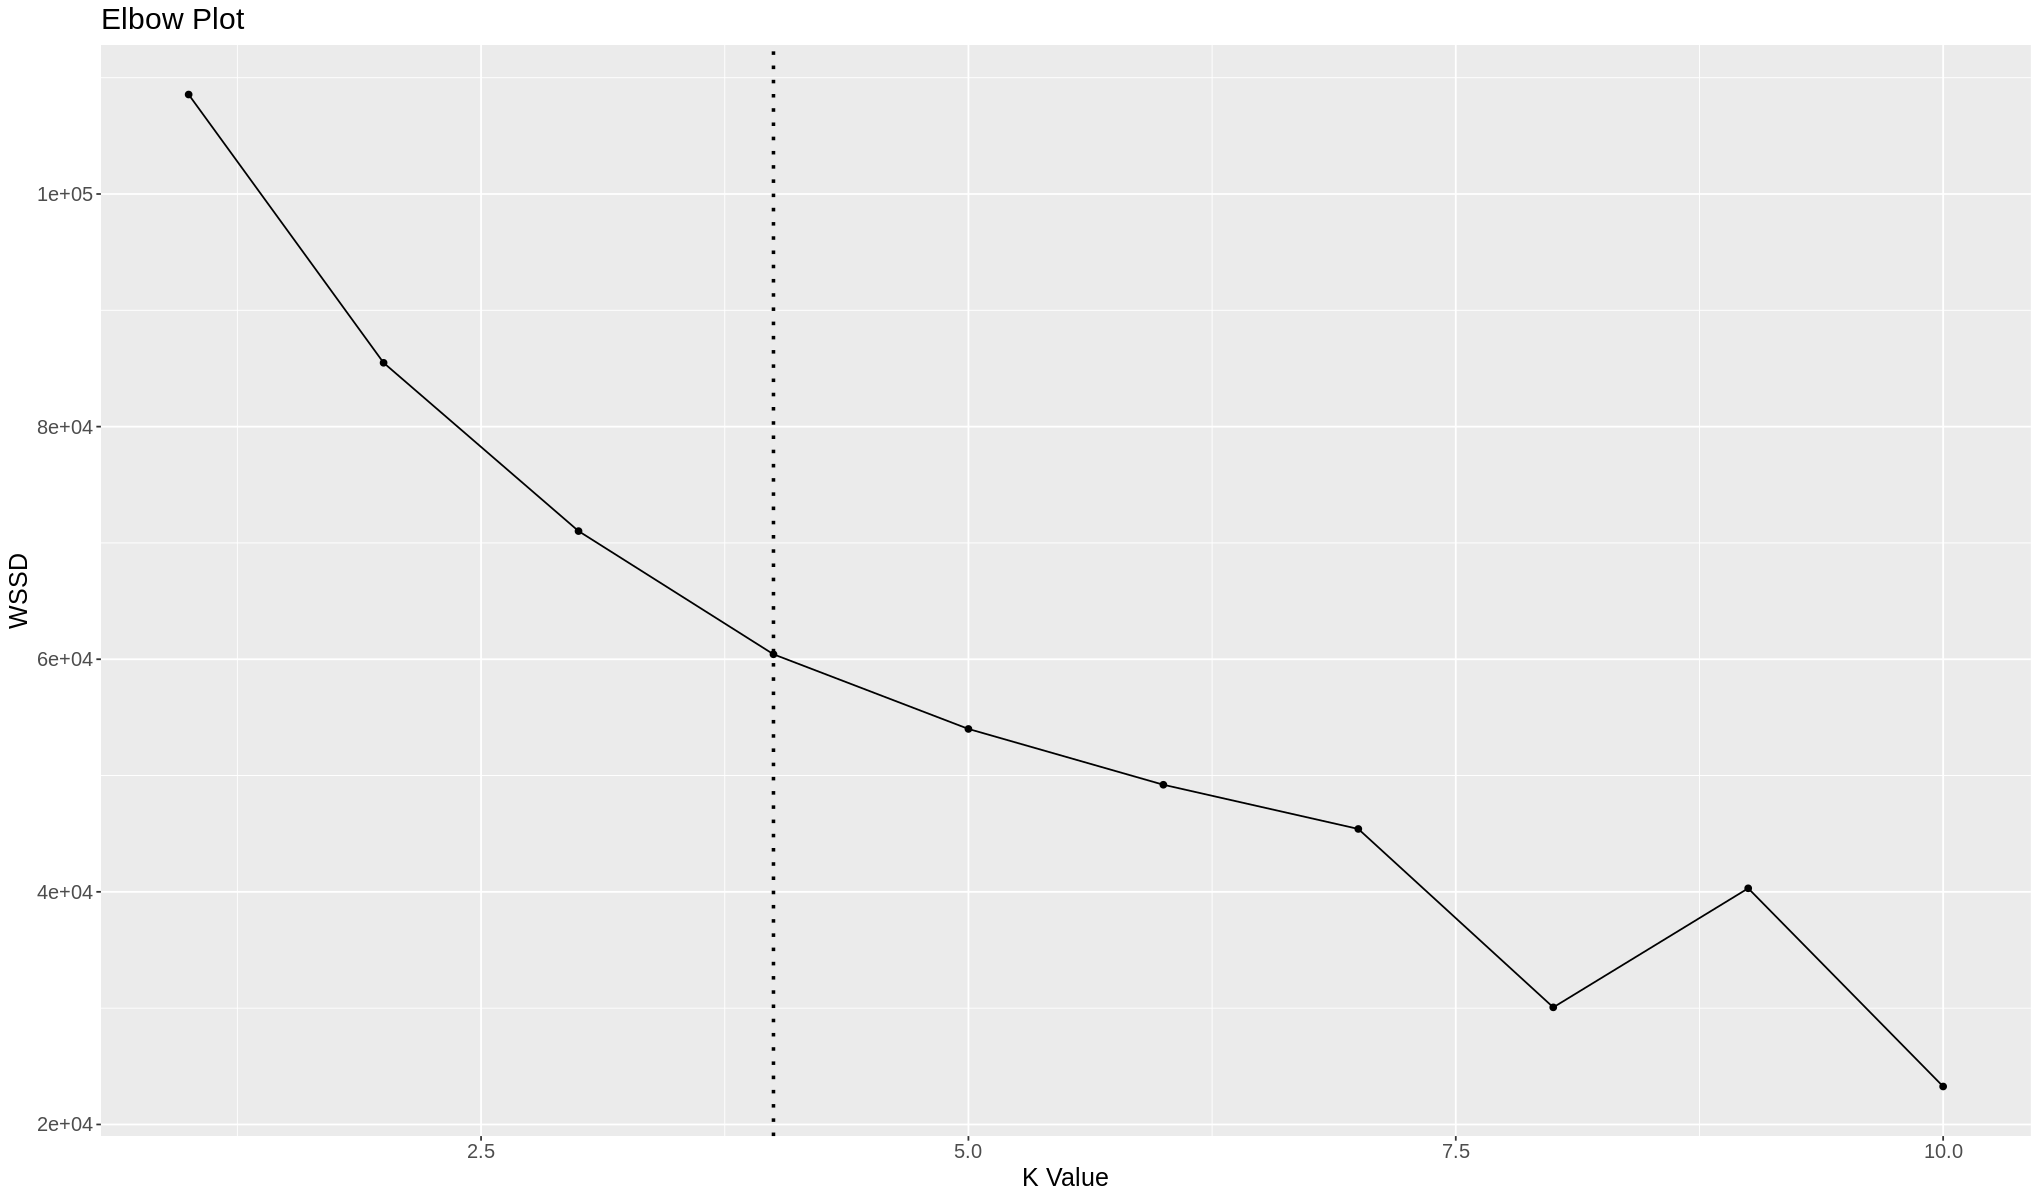

In [56]:
set.seed(9876)

#selecting for variables of interest, then scaling them all
scaled_property <- housing_aggregated |>
    select(AGGREGATE_CURRENT_LAND_VALUE, MEAN_YEAR_BUILT, lat, long) |> #change variables of interest here
    mutate(across(everything(), scale))

#gathering the information for the elbow plot to find k
elbow_stats <- tibble(k = 1:10) |>
    rowwise() |>
    mutate(cluster = list(kmeans(scaled_property, nstart = 30, k))) |>
    mutate(glanced = list(glance(cluster))) |>
    select(-cluster) |>
    unnest(glanced)

#making the elbow plot
elbow_plot <- elbow_stats |>
    ggplot(aes(x = k, y = tot.withinss)) +
    geom_point() +
    geom_line() +
    labs(x = "K Value", y = "WSSD", title = "Elbow Plot") +
    theme(text = element_text(size = 15)) +
    geom_vline(xintercept = 4, linetype = "dotted", size = 1)
elbow_plot

Based on the abovel elbow plot, it appears that k = 4 is the number of clusters that we will proceed with in our analysis (dotted line added for visibility, since the elbow is a little difficult to spot).

Now, we use kmeans to assign each data point to a cluster.

In [131]:
#kmeans
property_clusters <- kmeans(scaled_property, centers = 4) |>
    augment(scaled_property)

#seeing the number of properties in each cluster
cluster_count <- property_clusters |>
    group_by(.cluster) |>
    summarize(count = n())
cluster_count

.cluster,count
<fct>,<int>
1,5162
2,5907
3,9877
4,6193


We have now clustered each property into one of the 4 clusters. We can also see how many properties are in each cluster in the table above. Before proceeding, we will use density plots to see how each of the selected variables drove the clustering.

Warning message:
“Removed 1452 rows containing non-finite values (stat_density).”


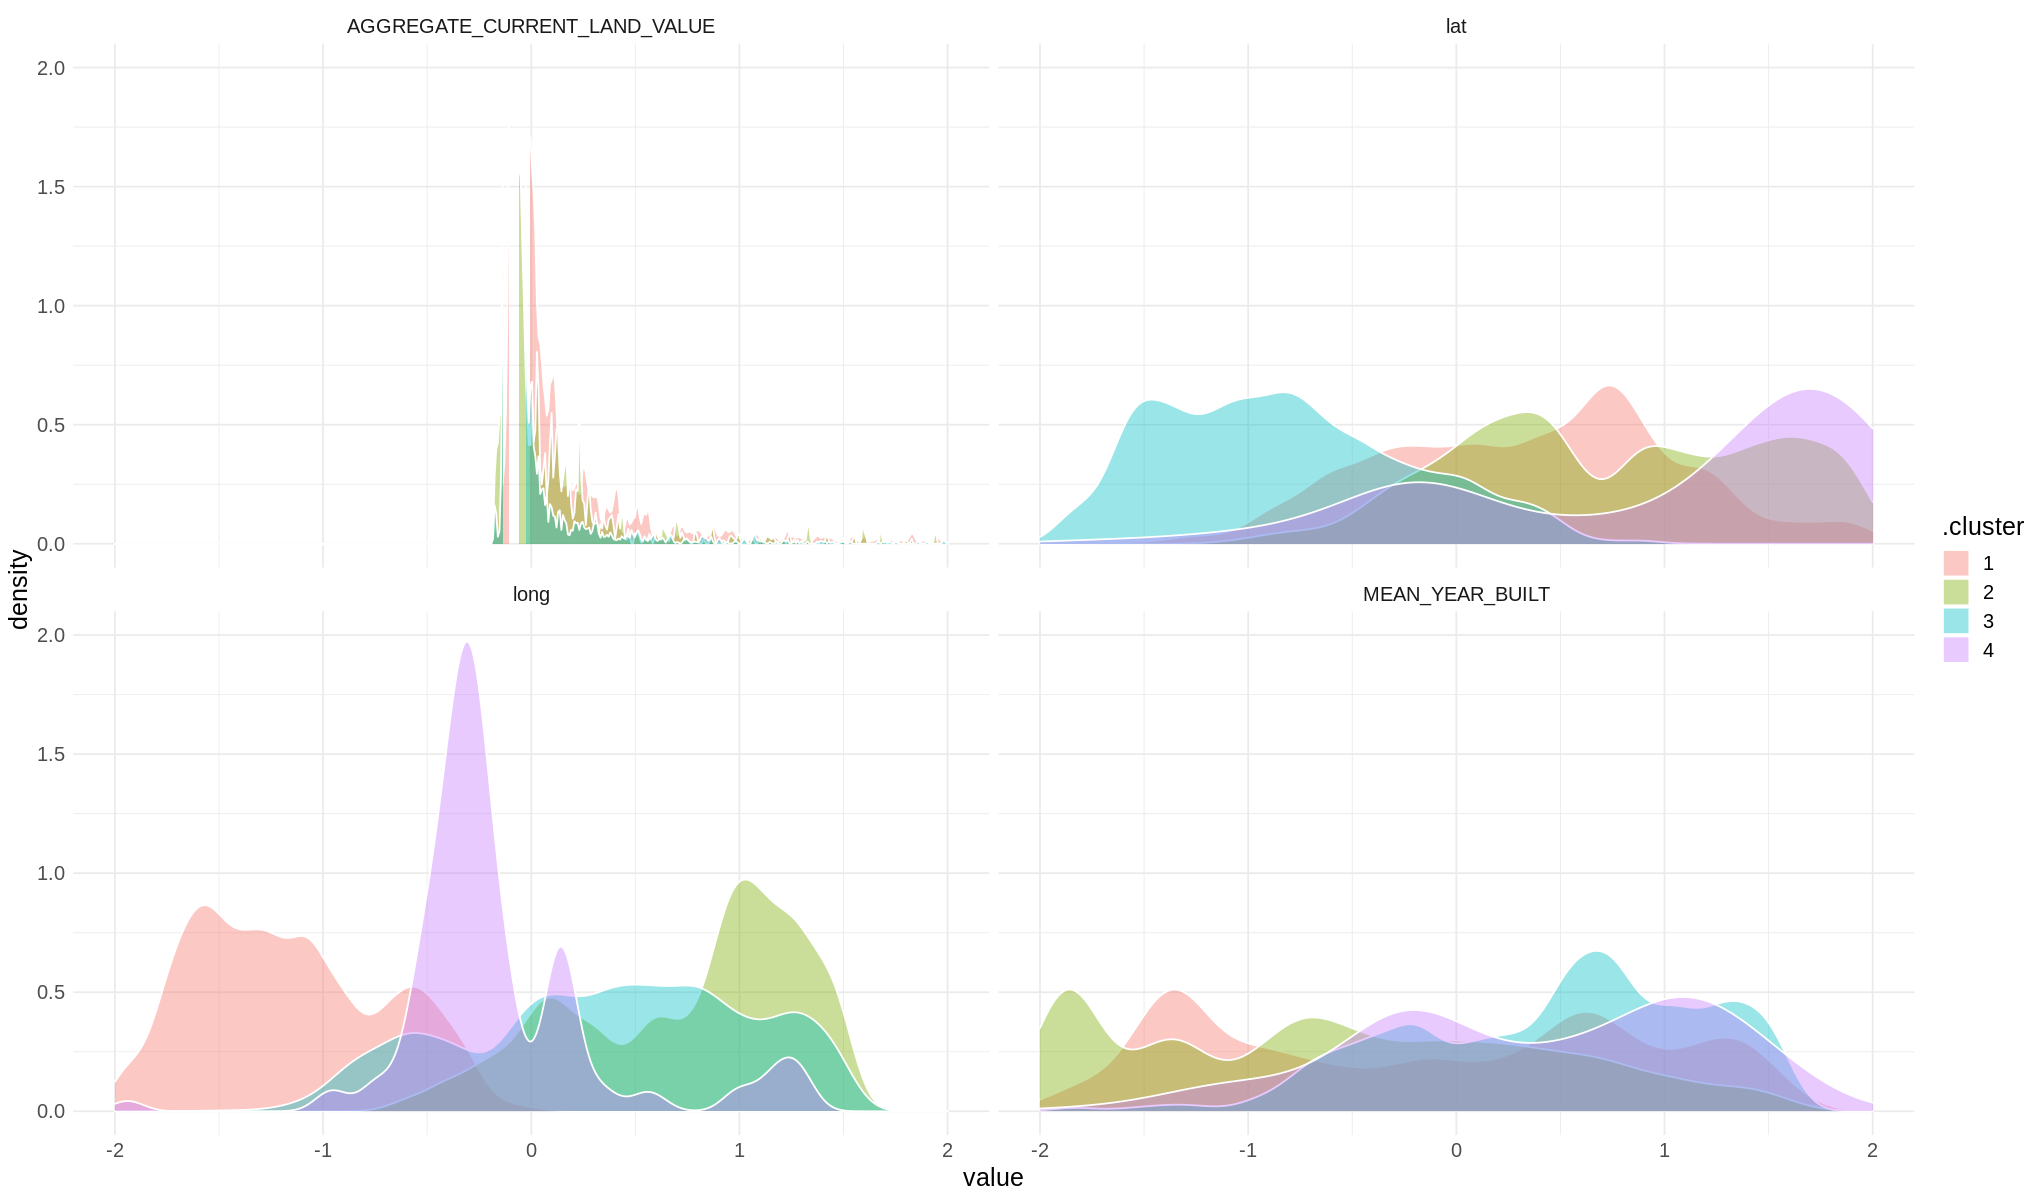

In [90]:
#density plots to see how each of the selected variables drives clustering
density_plots <- property_clusters |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(facets = vars(category)) +
        xlim(c(-2, 2)) +
        ylim(c(0, 2)) +
        theme_minimal() +
        theme(text = element_text(size = 15))
density_plots

For each of the variables, the density plots of each cluster has both overlapping and non_overlapping regions. The non-overlapping areas signify that each variable did drive the clustering.

<h1> 4. Clustering Model </h1>

To viesualize our clustering model, we first look at how land value and year built vary within clusters. We plot this using univariate distributions. We also calculate the means and standard deviations of these variables by cluster.

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 1356950)”
Warning message:
“Removed 3 rows containing missing values (geom_point).”


[1] "Properties with Land Value Above Cutoff (not visualized): 1"


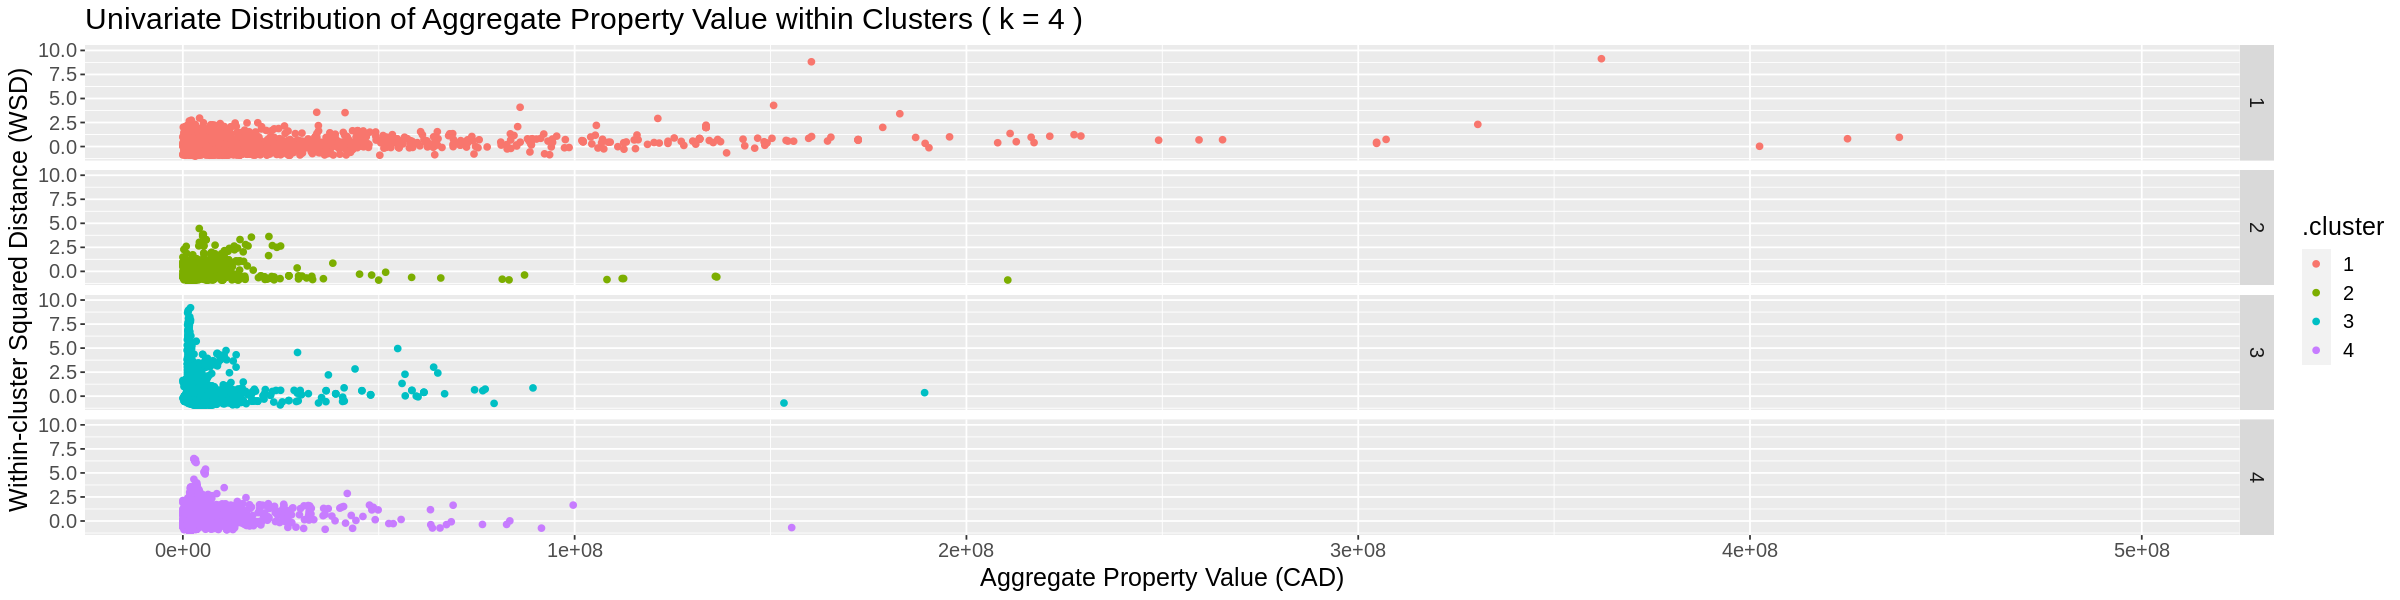

.cluster,avg_property_value,sd_property_value,avg_year_built,sd_year_built
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,11742283,57840901,1993.483,17.24108
2,2457602,5656710,1969.086,27.67868
3,3480480,5627694,1928.531,14.50764
4,2567182,4349526,1985.333,20.62067


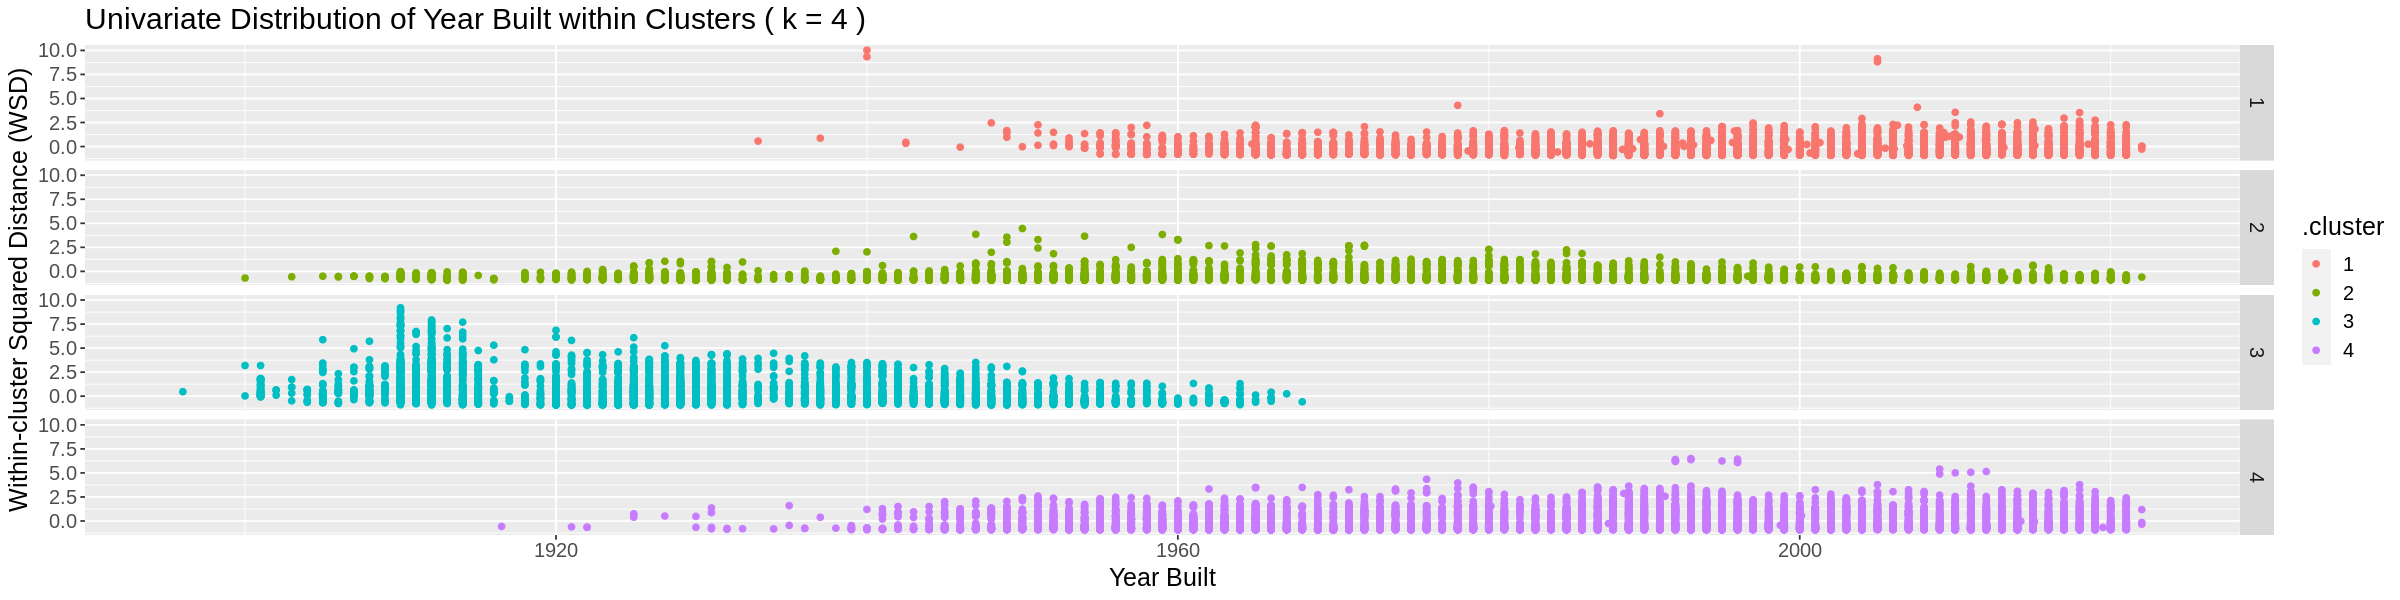

In [140]:
set.seed(seed)

## Data Specification with tuned k and selected features
# Selected k from Section 2 above
k <- 4

# Selected features from Section 2 above
housing_aggregated_selected <- housing_aggregated |>
                                select(AGGREGATE_CURRENT_LAND_VALUE,
                                       MEAN_YEAR_BUILT,
                                       lat,
                                       long)

# Calculated means and SDs of lat and long, for conversion out of scaled values
m_lat <- housing_aggregated |>
        select(lat) |>
        summarize(mean = mean(lat)) |>
        pull()
sd_lat <- m <- housing_aggregated |>
        select(lat) |>
        summarize(sd = sd(lat)) |>
        pull()
m_long <- housing_aggregated |>
        select(long) |>
        summarize(mean = mean(long)) |>
        pull()
sd_long <- m <- housing_aggregated |>
        select(long) |>
        summarize(sd = sd(long)) |>
        pull()

# Data scaling for clustering purposes
scaled_data <- housing_aggregated_selected |>
                mutate(across(everything(),scale)) 

## K-Means Model 
optimal_kmeans <- scaled_data |>
                    kmeans(centers = k, nstart = 50)

# Calculate unscaled lat and long
optimal_kmeans_centers <- optimal_kmeans$centers
optimal_kmeans_geo_centers <- as_tibble(optimal_kmeans_centers) |>
                                select(lat, long) |>
                                mutate(cluster_lat = (lat * sd_lat) + m_lat) |>
                                mutate(cluster_long = (long * sd_long) + m_long) |>
                                bind_cols(.cluster = as_factor(seq(from = 1, to = k, by = 1))) |>
                                select(cluster_lat, cluster_long, .cluster)

#Augmented Clustering Model for Distance Calculation
optimal_kmeans <- optimal_kmeans |>
                    augment(housing_aggregated)  

#Calculate within-cluster squared distance for each observation
optimal_kmeans_distances <- optimal_kmeans |>
                            left_join(optimal_kmeans_geo_centers, by = ".cluster", relationship = "many-to-many") |>
                            select(lat, long, cluster_lat, cluster_long) |>
                            mutate(WSD = (cluster_lat-lat)^2+(cluster_long-long)^2) |>
                            mutate(WSD_Scaled = scale(WSD)) |>
                            select(WSD, WSD_Scaled)
optimal_kmeans <- bind_cols(optimal_kmeans, optimal_kmeans_distances)

# Distribution of Current Property Value across clusters
options(repr.plot.width = 20, repr.plot.height =5)


#to cut off data points with current property values that are so high that they mess with the univariate distributions
cutoff <- 5*10^8 #in CAD

property_value_cluster_dist <- optimal_kmeans |> 
                                ggplot(aes(x=AGGREGATE_CURRENT_LAND_VALUE,y=WSD_Scaled,color=.cluster)) +
                                geom_point() +
                                facet_grid(rows = vars(.cluster)) +
                                labs(x = "Aggregate Property Value (CAD)", 
                                     y = "Within-cluster Squared Distance (WSD)", 
                                     title = paste("Univariate Distribution of Aggregate Property Value within Clusters ( k =",k,")")) +
                                xlim(c(0, cutoff)) +
                                theme(text = element_text(size = 15))
property_value_cluster_dist

#a count of data points with really exorbitant land values
#because they mess with the data presentation
above_cutoff <- housing_aggregated |>
    filter(AGGREGATE_CURRENT_LAND_VALUE > cutoff) |>
    summarize(count = n())
print(paste("Properties with Land Value Above Cutoff (not visualized):", nrow(above_cutoff)))

# Distribution of Year property is built across clusters
options(repr.plot.width = 20, repr.plot.height =5)
property_age_cluster_dist <- optimal_kmeans |> 
                                ggplot(aes(x=MEAN_YEAR_BUILT,y=WSD_Scaled,color=.cluster)) +
                                geom_point() +
                                facet_grid(rows = vars(.cluster)) +
                                labs(x = "Year Built", 
                                     y = "Within-cluster Squared Distance (WSD)", 
                                     title = paste("Univariate Distribution of Year Built within Clusters ( k =",k,")")) +
                                theme(text = element_text(size = 15))
property_age_cluster_dist

#summary stats of each cluster
summary_stats <- optimal_kmeans |>
    group_by(.cluster) |>
    summarize(avg_property_value = mean(AGGREGATE_CURRENT_LAND_VALUE),
              sd_property_value = sd(AGGREGATE_CURRENT_LAND_VALUE),
              avg_year_built = mean(MEAN_YEAR_BUILT),
              sd_year_built = sd(MEAN_YEAR_BUILT))
summary_stats

Important note: there was one property cut off from the univariate distribution. This property had a multi-billion land value and including it would have made visualization difficult.

Cluster 1 has the overall highest land value (and also the greatest variation in property value), as well as the newest buildings.

Cluster 2 has the overall lowest land value, but its properties have a fairly even spread in terms of they were built.

Cluster 3 has the second highest land value (not too far ahead the other cheaper clusters) and its buildings are the oldest.

Cluster 4 has the second lowest land value, but its buildings are also pretty new.

Plotting these cluster onto a map...

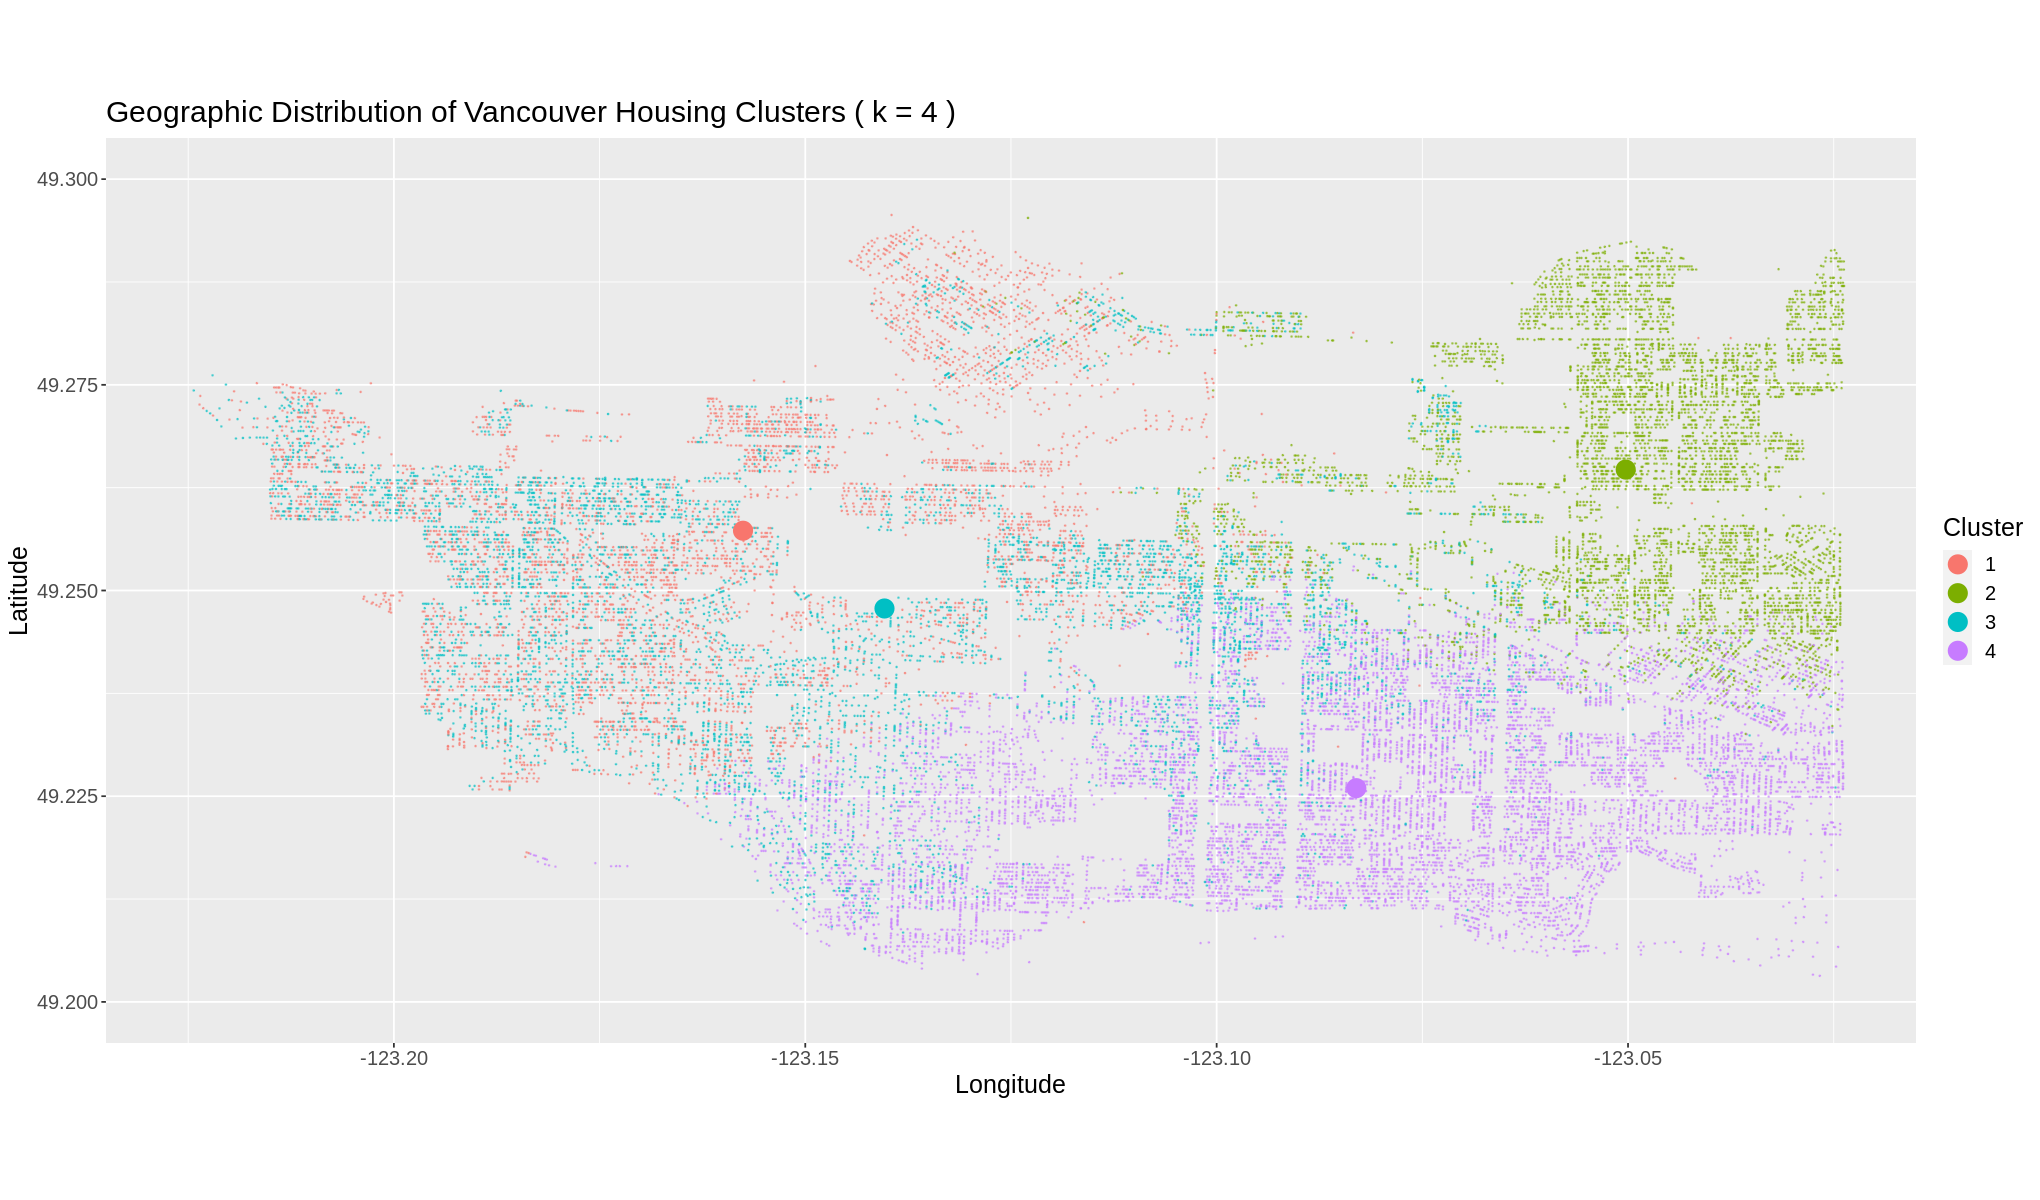

In [141]:
# Graph Geographic Distribution of Clusters
options(repr.plot.width = 17, repr.plot.height = 10)
cluster_geo_dist <- optimal_kmeans |>
                ggplot(aes(x=long,y=lat,color=.cluster)) +
                geom_point(alpha = 0.5, size = 0.125) +
                geom_point(data = optimal_kmeans_geo_centers, aes(x=cluster_long, y=cluster_lat), size = 5) +
                coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
                labs(x = "Longitude", y = "Latitude",
                     color = "Cluster",
                     title = paste("Geographic Distribution of Vancouver Housing Clusters ( k =",k,")")) +
                theme(text = element_text(size = 15))
cluster_geo_dist

Cluster 1 (highest value and newest) and cluster 3 (high value and old) correspond with downtown and west side Vancouver (includes Kerrisdale, Kitsilano, Dunbar, etc.).

Cluster 2 (cheapest with variable age) corresponds with the northern part of east side Vancouver (includes PNE, downtown eastside, Renfrew, etc.).

Cluster 4 (second cheapest but newer) corresponds with south and east Vancouver (includes Fraser, Sunset, Killarney, etc.).

Lastly, we assign each Vancouver neighbourhood to one of the 4 clusters based on which cluster predominates the region.

In [142]:
#assigning clusters to a data set that contains neighbourhood codes
hood_and_cluster <- property_clusters |>
    select(.cluster) |>
    bind_cols(housing_aggregated)

#grouping properties by neighbourhood, then finding the dominant cluster
assign_cluster_to_hood <- hood_and_cluster |>
    group_by(NEIGHBOURHOOD_CODE) |>
    summarize(major_cluster = Mode(.cluster)) |>
    bind_cols(neighbourhoods) |>
    rename(NEIGHBOURHOOD_CODE = NEIGHBOURHOOD_CODE...3) |>
    select(-NEIGHBOURHOOD_CODE...1)
assign_cluster_to_hood

New names:
• `NEIGHBOURHOOD_CODE` -> `NEIGHBOURHOOD_CODE...1`
• `NEIGHBOURHOOD_CODE` -> `NEIGHBOURHOOD_CODE...3`


major_cluster,NEIGHBOURHOOD_CODE,NEIGHBOURHOOD_NAME
<fct>,<chr>,<chr>
1,001,Point Grey
1,002,Kitsilano
4,003,Dunbar
1,004,Arbutus
1,005,Kerrisdale
4,006,Southlands
1,007,Fairview
4,008,Shaughnessy
4,009,South Granville


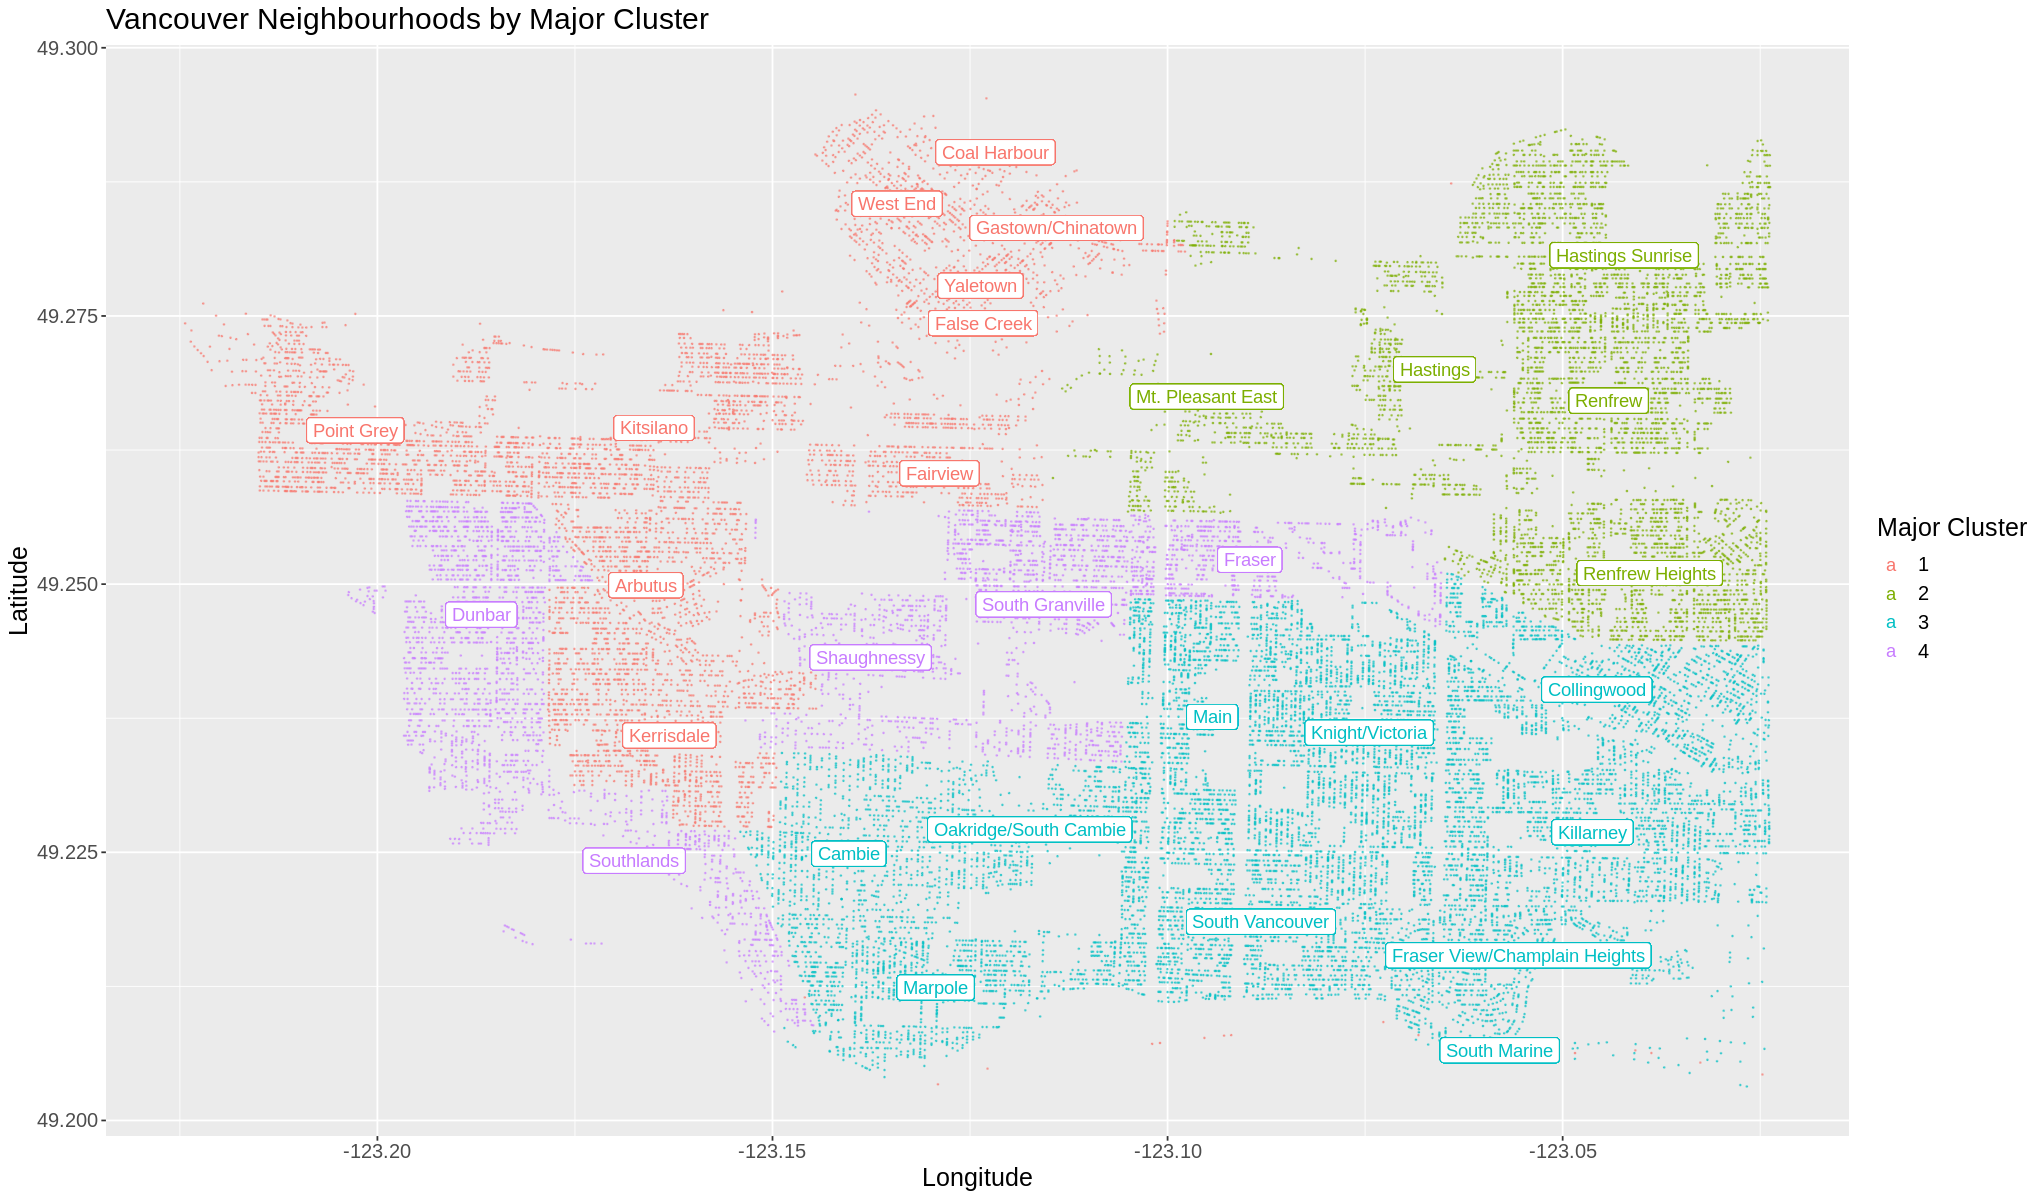

In [155]:
hood_major_cluster <- left_join(hood_and_cluster, assign_cluster_to_hood, by = "NEIGHBOURHOOD_CODE", relationship = "many-to-many") |>
                      inner_join(ptax_centroids, by = "NEIGHBOURHOOD_CODE", relationship = "many-to-many")

major_cluster_plot <- hood_major_cluster |>
    ggplot(aes(x = long, y = lat, color = major_cluster)) +
    geom_point(alpha = 0.5, size = 0.125) +
    # geom_point(aes(x = centroid_long, y = centroid_lat)) +
    geom_label(aes(x = centroid_long, y = centroid_lat, label = NEIGHBOURHOOD_NAME.x)) +
    #geom_label(data = ptax_centroids, aes(x = centroid_long, y = centroid_lat, label = NEIGHBOURHOOD_NAME), hjust = 0.125, vjust = 1.5) +
    # geom_point(data = ptax_centroids, aes(x = centroid_long, y = centroid_lat), size = 5) +
    # coord_fixed(ratio = 1, xlim = c(-123.225,-123.025), ylim = c(49.20, 49.30), expand = TRUE, clip = "on") +
    labs(x = "Longitude", y = "Latitude",
         color = "Major Cluster",
         title = "Vancouver Neighbourhoods by Major Cluster") +
                theme(text = element_text(size = 15))
major_cluster_plot

In [14]:
## Prediction Examples

# A potential property in Oakridge Center, currently under construction
# https://vancouver.ca/home-property-development/oakridge-redevelopment.aspx
Pred_1 <- tibble(lat = 49.23205459271654, long = -123.11868609998048, YEAR_BUILT = 2023, NEIGHBOURHOOD_CODE = "011")

# A potential transit-oriented development in the future Arbutus station
# https://buzzer.translink.ca/2023/03/translink-announces-first-real-estate-development-project/
Pred_2 <- tibble(lat = 49.26366041287987, long = -123.15280212903731, YEAR_BUILT = 2023, NEIGHBOURHOOD_CODE = "011")
# A potential 

<div class="alert alert-block alert-info">
<h1> Results </h1>
     
    Clusters:

After clustering properties by Aggregated Value and Year Built, there are four geolocation clusters of property in Vancouver. The longitude and latitude coordinates show that cluster 1 and cluster 3 overlap in West Vancouver and the Downtown area. Downtown Eastside and East Vancouver are represented by cluster 2. Cluster 4 covers South Vancouver. 
> - 1, 3: West Vancouver, Downtown
> - 2: East Vancouver
> - 4: South Vancouver

     Neighbourhood alignment:
> - Detailed map of dominant clusters in neighbourhoods: 
From the Vancouver Neighbourhoods by Major Cluster graph above, we can conclude that Point Grey, Kitsilano, West End, Coal Harbour, Yaletown, False Creek, Fairview, Arbutus, Gastown/Chinatown and Kerrisdale are in Cluster 1, which has the most newly built and valuable properties. Cluster 2, where the average property value is lowest, includes Hastings, Mt. Pleasant East, Renfrew, Renfrew Heights and Hastings Sunrise. In these neighbourhoods, property development has been going on for a hundred years and is ongoing. Dunbar, Southlands, Shaughnessy, South Granville and Fraser are covered by Cluster 3. They are unevenly distributed in West Vancouver. The distinction between them and Cluster 1 is they have relatively lower average property values, and most properties were built before 1960, which is older than neighbourhoods in Cluster 1, for example, Kitsilano and Fairview. Cambie, Marpolr, Oakridge/South, Main, Knight/Victoria, Collingwood, Killarney, Fraser View/Champlain, South Vancouver and South Marine occupy the South Vancouver area, where the properties are mostly built after 1940 with the lower value similar to the Downtown Eastside Cluster, Cluster 2. Overall, property value is geographically distinct across Vancouver. The average value of Cluster 1, representing West Vancouver, is 5 times more than the house value in the Downtown Eastside cluster.
The West Side of Vancouver appears to be distinguished by old versus new buildings. East and South Vancouver have a uniform distribution of property ages and property values, with more distinct boundaries.

> - Theory for missing data in Downtown Eastside: Other than local parks, the presence of tents and makeshift vendors have sprung up along East Hastings Street between Main and Carrall Streets as the area has seen a drastic increase in homelessness (Little, Karamali, 2022)

    
</div>    

<div class="alert alert-block alert-info">
<h1> Discussion </h1>
After clustering properties by Aggregated Value and Year Built, there are four geolocation clusters of property in Vancouver. The longitude and latitude coordinates show that clusters 1 and 3 overlap in West Vancouver and the Downtown area. Downtown Eastside and East Vancouver are represented by cluster 2 while cluster 4 covers South Vancouver. In comparison to our expected findings, we predicted less clusters than the amount of neighbourhoods and this turned out to be the case. 

For the significance of our findings, our model clusters appear to be able to  characterise regional disparities in wealth and development. From our plot, it can be seen that the cluster corresponding to East Vancouver contains lower property values and older buildings. Robert Fishman uses the term “technoburbia” to describe the form of urban development that jumbles business, residential, commercial, and other uses together in the area surrounding older core cities (LeGates, 2020). Our findings suggest the existence of a localised “technoburbia” in the West Vancouver region, as the two relevant clusters appear to have distinctly separate distributions of year built. West Vancouver, where the older properties are built, is surrounded by many multifunctional young neighbourhoods. The pertinent clustering variables could help with “geodemographic marketing”.

Future models could explore longitudinal temporal effects on clustering by including property tax data from different years. In Canada and the U.S., suburban environments are dominated by privatism, home ownership, and competing governments whose priority is to protect property values (LeGates, 2020). A longitudinal study could more strongly suggest spatial biases in municipal planning with regards to property value. Furthermore, the spatial effects of features and amenities could be explored, such as the role of transit, public art, and proximity to services (etc.). Analyzing the spatial effects of non-housing zoning could also prove to be influential in clustering. According to Joel Garreau, “Suburbia is no longer subsidiary or subordinate to the central city.  Instead, we have suburban downtowns, also called ‘edge cities’.” (LeGates, 2020).  

In addition, some future questions that our project could lead to are as follows: What other variables could more effectively distinguish neighbourhoods? Could these 4 clusters suggest that property valuation in their associated areas behave differently? How might real-estate investors and property developers consider the region of a property in their project valuations?
    
    
</div>    

<h1> References and Resources </h1>

> City of Vancouver. (2023). Property tax report [Data set]. 
https://opendata.vancouver.ca/explore/dataset/property-tax-report/information/

>  City of Vancouver. (2023). Property parcel polygons [Data set].
https://opendata.vancouver.ca/explore/dataset/property-parcel-polygons/information/?disjunctive.streetname

> Fik, T. J., Ling, D. C., &amp; Mulligan, G. F. (2003). Modeling spatial variation in housing 
prices: A variable interaction approach. Real Estate Economics, 31(4), 623–646. 
https://doi.org/10.1046/j.1080-8620.2003.00079.x

> LeGates, R. T., &amp; Stout, F. (2020). Part 8 Cities in a Global Society. In The City
Reader 6th Edition (pp. 641–644). essay, Routledge. 

> Little, S., &amp; Karamali, K. (2022, July 8). Vancouver has a new tent city. This time it’s 
in the street, not a Park. Global News. 
https://globalnews.ca/news/8973620/vancouver-hastings-street-tent-city/
